# 예제 1 : 우편번호 인식기 v2
- 1.1. LeNet 재현
- 1.2. 우편번호 인식기 v2 구현

## 1.1 : LeNet 재현

### 라이브러리 불러오기

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.datasets as ds

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dropout,Dense,Input
from tensorflow.keras.optimizers import Adam

### 데이터 준비

In [3]:
(x_train,y_train),(x_test,y_test)=ds.mnist.load_data()
x_train.shape

(60000, 28, 28)

In [4]:
x_train=x_train.reshape(60000,28,28,1)
x_test=x_test.reshape(10000,28,28,1)
x_train.shape

(60000, 28, 28, 1)

In [5]:
x_train=x_train.astype(np.float32)/255.0
x_test=x_test.astype(np.float32)/255.0

In [6]:
y_train=tf.keras.utils.to_categorical(y_train,10)
y_test=tf.keras.utils.to_categorical(y_test,10)

### 모델 정의

In [7]:
cnn=Sequential()
input = Input(shape=(28,28,1))
cnn.add(input)
cnn.add(Conv2D(6,(5,5),padding='same',activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2),strides=2))
cnn.add(Conv2D(16,(5,5),padding='valid',activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2,2),strides=2))
cnn.add(Conv2D(120,(5,5),padding='valid',activation='relu'))
cnn.add(Flatten())
cnn.add(Dense(units=84,activation='relu'))
cnn.add(Dense(units=10,activation='softmax'))

### 학습 및 평가

In [8]:
cnn.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])
cnn.fit(x_train,y_train,batch_size=128,epochs=30,validation_data=(x_test,y_test),verbose=2)

Epoch 1/30
469/469 - 9s - 19ms/step - accuracy: 0.9132 - loss: 0.2922 - val_accuracy: 0.9732 - val_loss: 0.0880
Epoch 2/30
469/469 - 5s - 11ms/step - accuracy: 0.9746 - loss: 0.0808 - val_accuracy: 0.9827 - val_loss: 0.0563
Epoch 3/30
469/469 - 5s - 11ms/step - accuracy: 0.9814 - loss: 0.0590 - val_accuracy: 0.9847 - val_loss: 0.0492
Epoch 4/30
469/469 - 6s - 12ms/step - accuracy: 0.9850 - loss: 0.0460 - val_accuracy: 0.9847 - val_loss: 0.0471
Epoch 5/30
469/469 - 6s - 12ms/step - accuracy: 0.9876 - loss: 0.0380 - val_accuracy: 0.9883 - val_loss: 0.0386
Epoch 6/30
469/469 - 5s - 11ms/step - accuracy: 0.9900 - loss: 0.0312 - val_accuracy: 0.9890 - val_loss: 0.0370
Epoch 7/30
469/469 - 5s - 11ms/step - accuracy: 0.9913 - loss: 0.0267 - val_accuracy: 0.9841 - val_loss: 0.0527
Epoch 8/30
469/469 - 5s - 11ms/step - accuracy: 0.9922 - loss: 0.0234 - val_accuracy: 0.9896 - val_loss: 0.0335
Epoch 9/30
469/469 - 5s - 11ms/step - accuracy: 0.9930 - loss: 0.0207 - val_accuracy: 0.9878 - val_loss:

In [9]:
res=cnn.evaluate(x_test,y_test,verbose=0)
print('정확도=',res[1]*100)

정확도= 99.05999898910522


### 모델 저장

In [10]:
cnn.save('cnn_v2.h5')

## 1.2. : 우편번호 인식기 v2 구현

### 라이브러리 불러오기

In [11]:
## 라이브러리 불러오기
import numpy as np
import tensorflow as tf
import cv2 as cv
import matplotlib.pyplot as plt

### 저장한 모델 불러오기

- `LeNet` 재현 실습을 통해 저장한 모델 불러오기
- MNIST 데이터셋으로 학습된 손글씨 숫자 인식 모델

In [12]:
model = tf.keras.models.load_model('cnn_v2.h5')

### 초기화 함수 정의
- 우편번호 작성 화면 초기화
- 5개의 숫자를 작성할 수 있는 영역 생성, 안내 텍스트 표시

In [13]:
def reset():
    global img
    img = np.ones((200, 520, 3), dtype=np.uint8) * 255
    for i in range(5):
        cv.rectangle(img, (10 + i * 100, 50), (10 + (i + 1) * 100, 150), (0, 0, 255))
    cv.putText(img, 'e:erase s:show r:recognition q:quit', (10, 40), cv.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 1)

### 숫자 추출 함수 정의
- 작성된 숫자를 추출하여 모델이 처리할 수 있는 형태로 변환
- 각 숫자는 28x28 크기로 리사이즈, 흑백으로 변환

In [14]:
def grab_numerals():
    numerals = []
    for i in range(5):
        roi = img[51:149, 11 + i * 100:9 + (i + 1) * 100, 0]
        roi = 255 - cv.resize(roi, (28, 28), interpolation=cv.INTER_CUBIC)
        numerals.append(roi)
    numerals = np.array(numerals)
    return numerals

### 숫자 시각화 함수 정의

- 추출된 숫자를 화면에 표시
- 사용자가 작성한 숫자 확인 가능

In [15]:
def show():
    numerals = grab_numerals()
    plt.figure(figsize=(25, 5))
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(numerals[i], cmap='gray')
        plt.xticks([]); plt.yticks([])
    plt.show()

### 숫자 인식 함수 정의
- 추출된 숫자를 모델에 입력하여 예측
- 예측된 숫자는 화면에 표시되고 소리를 재생함

In [16]:
def recognition():
    numerals = grab_numerals()
    numerals = numerals.reshape(5, 28, 28) # 지난 실습 7-7.ipynb (5, 784)에서 (5, 28, 28) 로 변경
    numerals = numerals.astype(np.float32) / 255.0
    res = model.predict(numerals)  # 신경망 모델로 예측
    class_id = np.argmax(res, axis=1)
    for i in range(5):
        cv.putText(img, str(class_id[i]), (50 + i * 100, 180), cv.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 1)
    # winsound.Beep(1000, 500)

### 마우스 이벤트 처리

- 왼쪽 버튼을 클릭하거나 드래그하면 숫자를 작성할 수 있음

In [17]:
BrushSiz = 4
LColor = (0, 0, 0)

def writing(event, x, y, flags, param):
    if event == cv.EVENT_LBUTTONDOWN:
        cv.circle(img, (x, y), BrushSiz, LColor, -1)
    elif event == cv.EVENT_MOUSEMOVE and flags == cv.EVENT_FLAG_LBUTTON:
        cv.circle(img, (x, y), BrushSiz, LColor, -1)

### 메인 루프

- 사용자는 'e', 's', 'r', 'q' 키를 사용하여 초기화, 시각화, 인식, 종료를 수행함

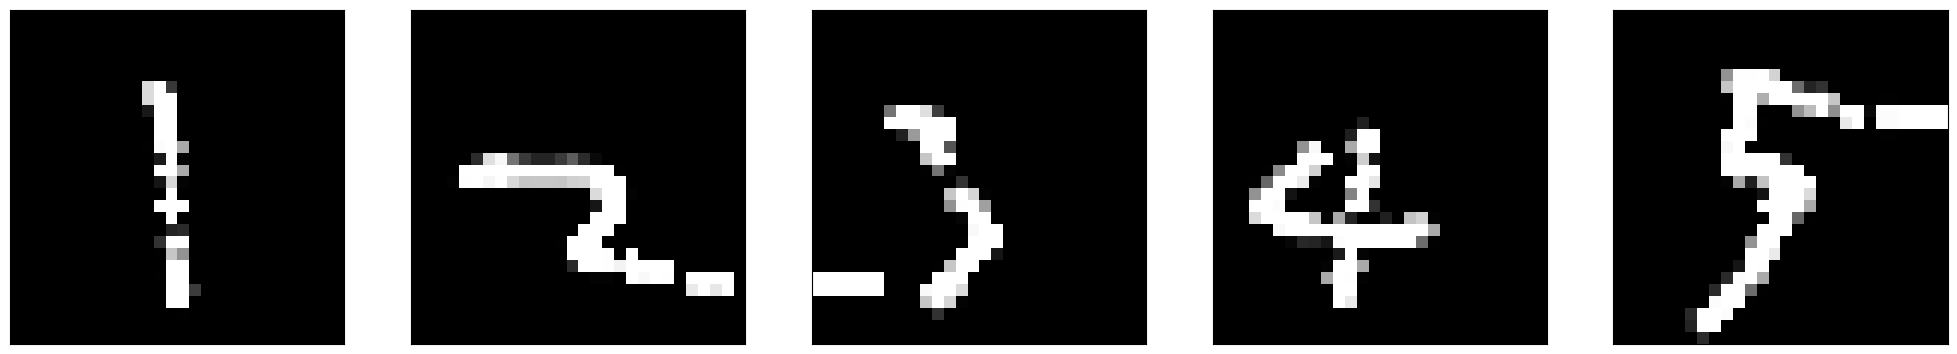

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [18]:
reset()
cv.namedWindow('Writing')
cv.setMouseCallback('Writing', writing)

while True:
    cv.imshow('Writing', img)
    key = cv.waitKey(1)
    if key == ord('e'):
        reset()
    elif key == ord('s'):
        show()
    elif key == ord('r'):
        recognition()
    elif key == ord('q'):
        break

cv.destroyAllWindows()